In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_20250901
import simulate
from sklearn.metrics import r2_score
import importlib


c:\Users\haley\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"
random_seed = 2025
r2 = 0.5
n = 1000
dim = 112
coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)

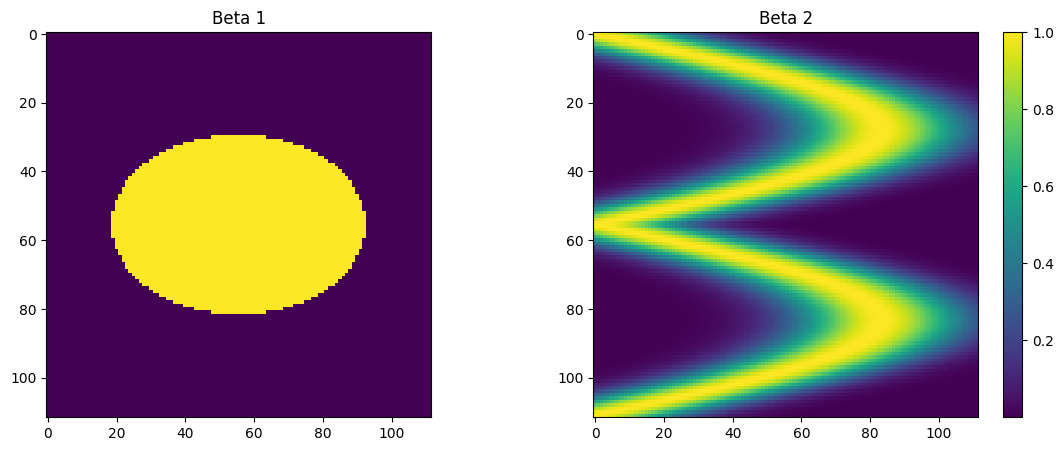

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (14,5))
axs[0].imshow(true_beta[0].reshape(dim, dim))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta[1].reshape(dim, dim))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show()



In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

image_data_0_reshaped = img_data[0].reshape(n, dim, dim)
image_data_1_reshaped = img_data[1].reshape(n, dim, dim)

stacked_img = np.concatenate([image_data_0_reshaped, image_data_1_reshaped], axis = 1)
stacked_img = stacked_img[:, np.newaxis, :, :]

y = y.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)
stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(stacked_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
train_dataset = TensorDataset(X_train, y_train)
test_dataset =  TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [5]:
def train_cnn_model(model_class=model_20250901.CNN_3_3_16_512, 
                    lr=0.001, 
                    weight_decay=0.0, 
                    num_epochs=20, 
                    train_loader=None, 
                    test_loader=None, 
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=True,
                    plot_results=True):
    """
    Train a CNN model with customizable parameters and track performance metrics.
    
    Args:
        model_class: CNN model class (default: CNN_3_3_16_512)
        lr: Learning rate (default: 0.001)
        weight_decay: L2 regularization (default: 0.0)
        num_epochs: Number of training epochs (default: 50)
        train_loader: Training data loader
        test_loader: Test/validation data loader
        device: Device to run training on
        verbose: Whether to print training progress
        plot_results: Whether to plot learning curves
    
    Returns:
        Dictionary containing training history and best metrics
    """
    # Initialize model, criterion and optimizer
    cnn = model_class().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize lists to track metrics
    train_losses = []
    test_losses = []
    all_train_r2 = []
    all_test_r2 = []
    
    best_epoch = 0
    best_test_loss = float('inf')
    best_test_r2 = -float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        cnn.train()
        running_loss = 0.0
        y_pred, y_true = [], []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_hat_batch = cnn(X_batch)
            loss = criterion(y_hat_batch, y_batch)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                y_true.extend(y_batch.cpu().numpy().flatten())
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_r2 = r2_score(y_true, y_pred)
        all_train_r2.append(train_r2)
        
        # --- Validation/Test Phase ---
        cnn.eval()
        with torch.no_grad():
            test_pred, test_true = [], []
            test_running_loss = 0.0
            
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_hat_batch = cnn(X_batch)
                loss = criterion(y_hat_batch, y_batch)
                test_running_loss += loss.item()
                test_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                test_true.extend(y_batch.cpu().numpy().flatten())
            
            epoch_test_loss = test_running_loss / len(test_loader)
            test_losses.append(epoch_test_loss)
            test_r2 = r2_score(test_true, test_pred)
            all_test_r2.append(test_r2)
            
            # Update best epoch
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                best_test_r2 = test_r2
                best_epoch = epoch + 1
        
        # Print metrics if verbose
        # if verbose and (epoch + 1) % 1 == 0:
        #     print(f"Epoch {epoch + 1}/{num_epochs}")
        #     print(f"  Train Loss: {epoch_train_loss:.4f} ± {np.std(train_losses):.4f}")
        #     print(f"  Train R²: {train_r2:.4f} ± {np.std(all_train_r2):.4f}")
        #     print(f"  Test Loss: {epoch_test_loss:.4f} ± {np.std(test_losses):.4f}")
        #     print(f"  Test R²: {test_r2:.4f} ± {np.std(all_test_r2):.4f}\n")

    # Final summary
    if verbose:
        print(f"\n=== {model_class.__name__} Training Summary ===")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Test Loss: {best_test_loss:.4f}")
        print(f"Corresponding Test R²: {best_test_r2:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f} ± {np.std(train_losses):.4f}")
        print(f"Final Train R²: {all_train_r2[-1]:.4f} ± {np.std(all_train_r2):.4f}")
        print(f"Final Test Loss: {test_losses[-1]:.4f} ± {np.std(test_losses):.4f}")
        print(f"Final Test R²: {all_test_r2[-1]:.4f} ± {np.std(all_test_r2):.4f}")

    # Plot results if requested
    if plot_results:
        plt.figure(figsize=(12, 5))

        # Plot Losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(f'{model_class.__name__} Training & Test Loss')
        plt.legend()

        # Plot R² Scores
        plt.subplot(1, 2, 2)
        plt.plot(all_train_r2, label='Train R²')
        plt.plot(all_test_r2, label='Test R²')
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.title(f'{model_class.__name__} R² Scores')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return {
        'model': cnn,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': all_train_r2,
        'test_r2_scores': all_test_r2,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_r2': best_test_r2,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_r2': all_train_r2[-1],
        'final_test_r2': all_test_r2[-1]
    }

# Example usage:
# results = train_cnn_model(model_class=model.CNN2d512,
#                         lr=0.0001,
#                         weight_decay=0.01,
#                         num_epochs=100,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [6]:
import model_20250901
importlib.reload(model_20250901)      # Force-reload the module
from model_20250901 import CNN_3_3_16_512, CNN_2_2_16_512, CNN_3_3_16_256 , CNN_2_2_16_256 , CNN_3_3_8_256, CNN_2_2_8_256, CNN_3_3_8_128, CNN_2_2_8_128, CNN_3_3_16_128, CNN_2_2_16_128       # Import the updated class


=== CNN_3_3_16_512 Training Summary ===
Best Epoch: 18
Best Test Loss: 104.5280
Corresponding Test R²: 0.3282
Final Train Loss: 33.4567 ± 24.1350
Final Train R²: 0.7844 ± 0.1555
Final Test Loss: 110.8140 ± 148.4411
Final Test R²: 0.2932 ± 0.9769


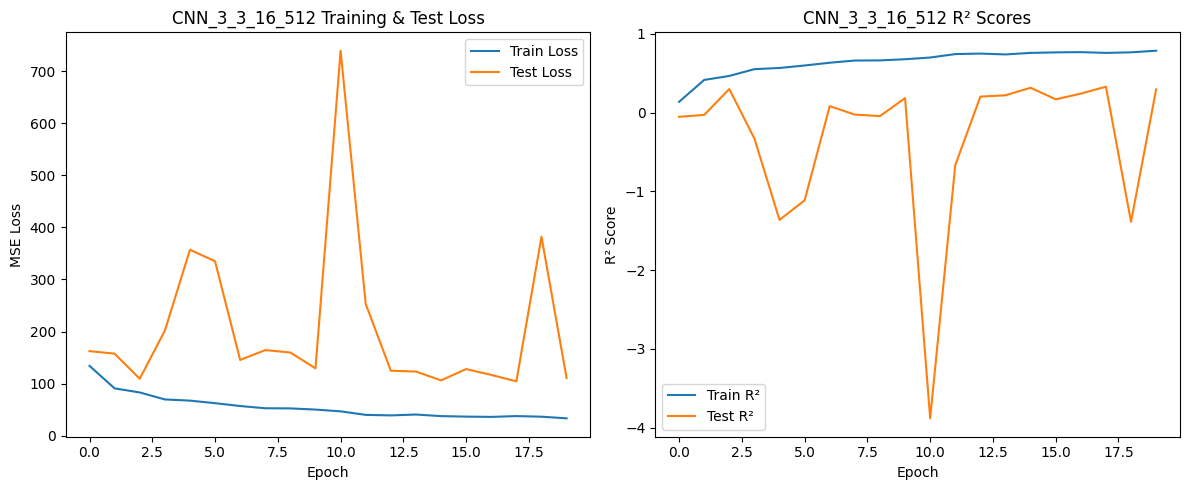

In [7]:
# session 1
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_512 Training Summary ===
Best Epoch: 19
Best Test Loss: 91.2585
Corresponding Test R²: 0.4139
Final Train Loss: 62.5567 ± 29.7300
Final Train R²: 0.5969 ± 0.1916
Final Test Loss: 92.8680 ± 21.2871
Final Test R²: 0.4009 ± 0.1395


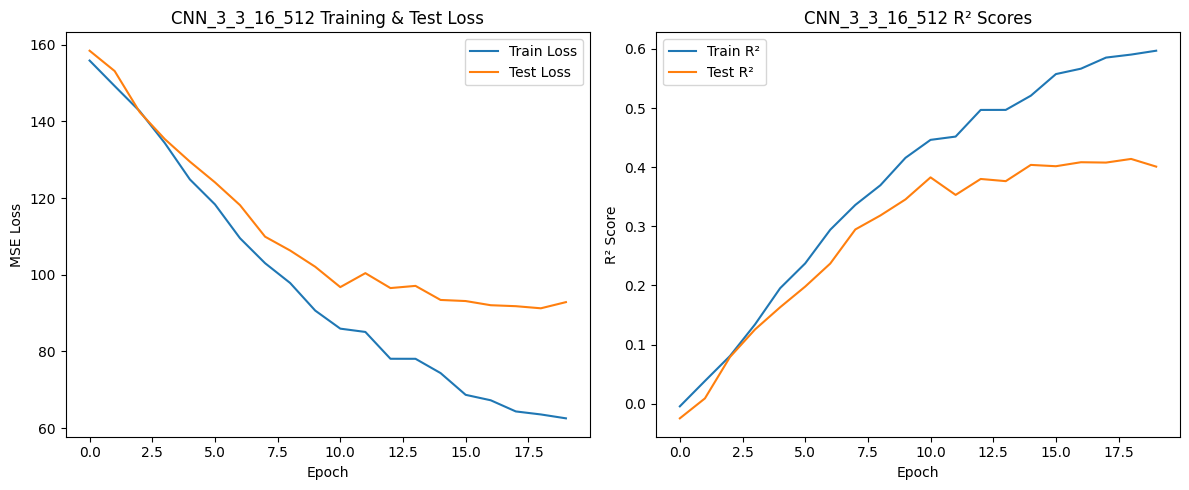

In [8]:
# session 2 
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_512 Training Summary ===
Best Epoch: 20
Best Test Loss: 96.6434
Corresponding Test R²: 0.3868
Final Train Loss: 68.8704 ± 22.2742
Final Train R²: 0.5562 ± 0.1435
Final Test Loss: 96.6434 ± 131.7234
Final Test R²: 0.3868 ± 0.8707


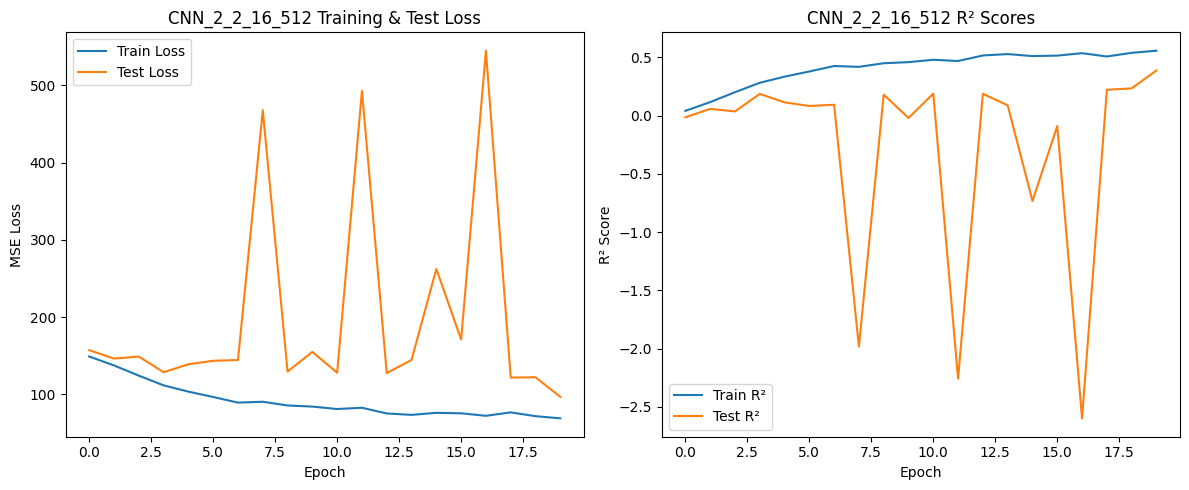

In [32]:
# session 3 
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_512 Training Summary ===
Best Epoch: 20
Best Test Loss: 131.7018
Corresponding Test R²: 0.1556
Final Train Loss: 127.5254 ± 8.4417
Final Train R²: 0.1782 ± 0.0544
Final Test Loss: 131.7018 ± 8.3609
Final Test R²: 0.1556 ± 0.0569


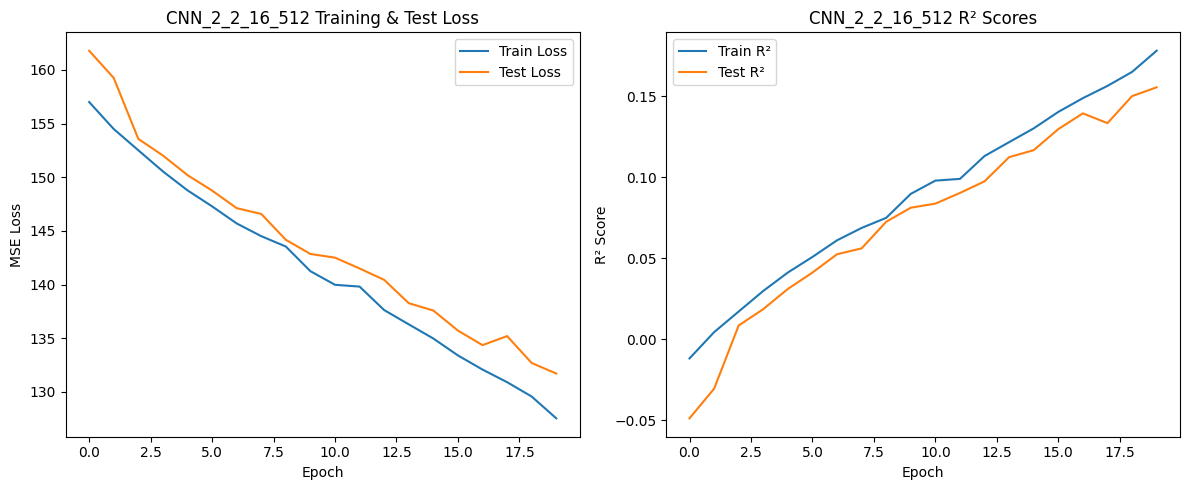

In [10]:
# session 4
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_256 Training Summary ===
Best Epoch: 19
Best Test Loss: 92.1504
Corresponding Test R²: 0.3939
Final Train Loss: 44.6092 ± 25.7523
Final Train R²: 0.7125 ± 0.1659
Final Test Loss: 192.3462 ± 129.7826
Final Test R²: -0.2795 ± 0.8318


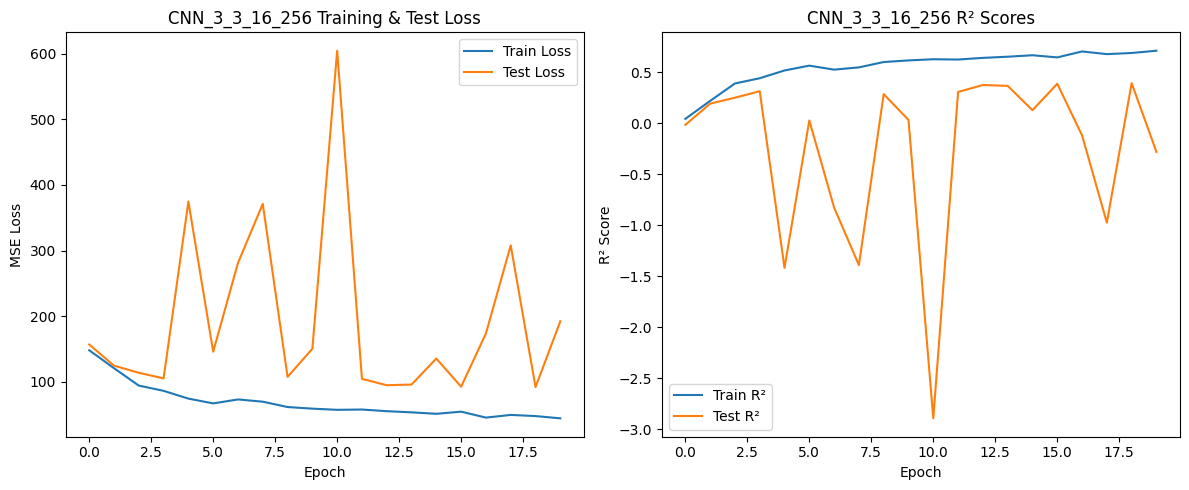

In [11]:
# session 5
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_256 Training Summary ===
Best Epoch: 18
Best Test Loss: 105.5262
Corresponding Test R²: 0.3297
Final Train Loss: 83.9199 ± 23.1438
Final Train R²: 0.4592 ± 0.1491
Final Test Loss: 106.7890 ± 17.3695
Final Test R²: 0.3238 ± 0.1160


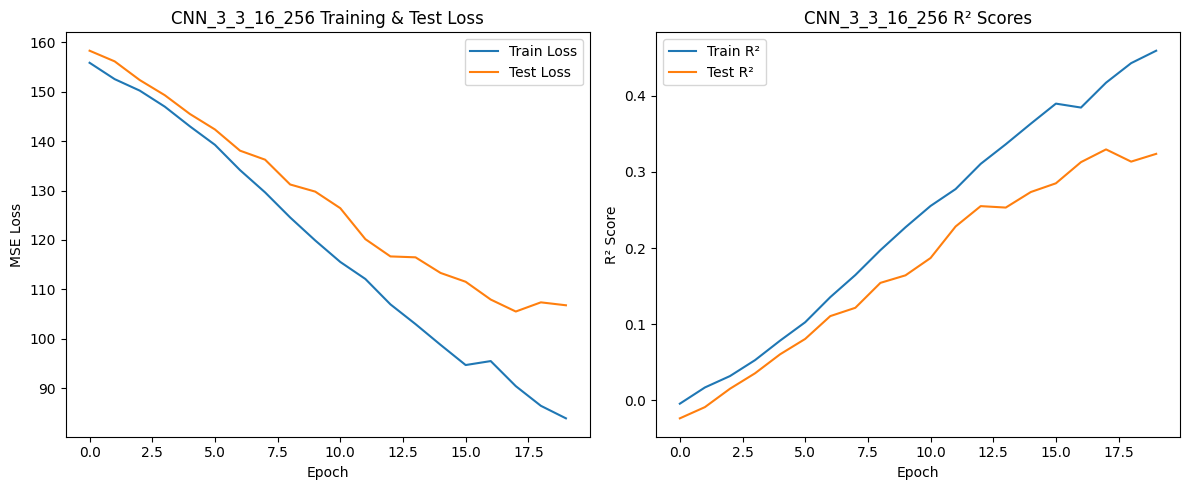

In [12]:
# session 6

results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_256 Training Summary ===
Best Epoch: 16
Best Test Loss: 129.9357
Corresponding Test R²: 0.1580
Final Train Loss: 71.0379 ± 24.6890
Final Train R²: 0.5422 ± 0.1591
Final Test Loss: 137.7207 ± 77.0680
Final Test R²: 0.1049 ± 0.4937


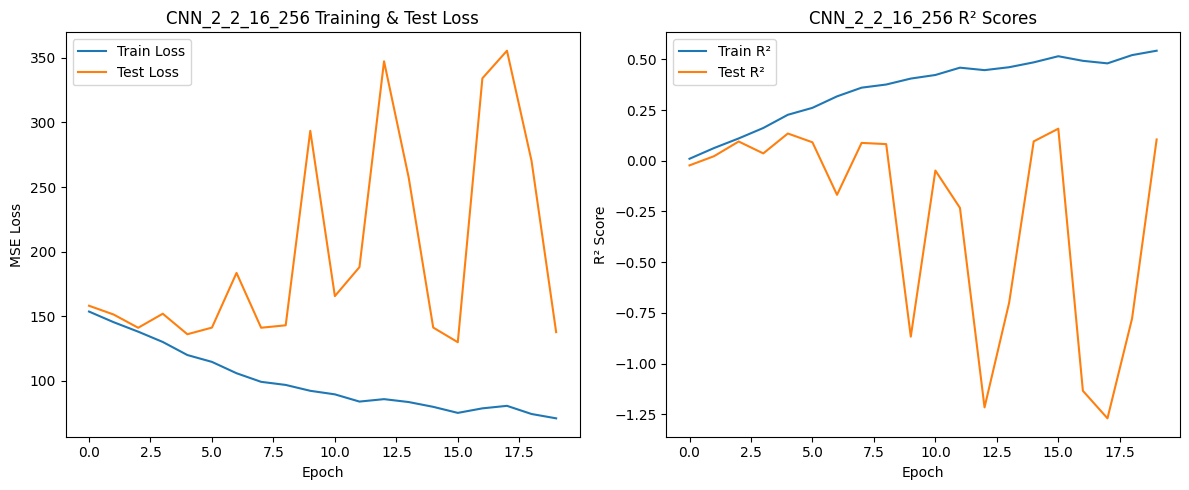

In [13]:
# session 7
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_256 Training Summary ===
Best Epoch: 20
Best Test Loss: 142.0226
Corresponding Test R²: 0.0875
Final Train Loss: 138.1319 ± 5.4816
Final Train R²: 0.1099 ± 0.0353
Final Test Loss: 142.0226 ± 5.1852
Final Test R²: 0.0875 ± 0.0355


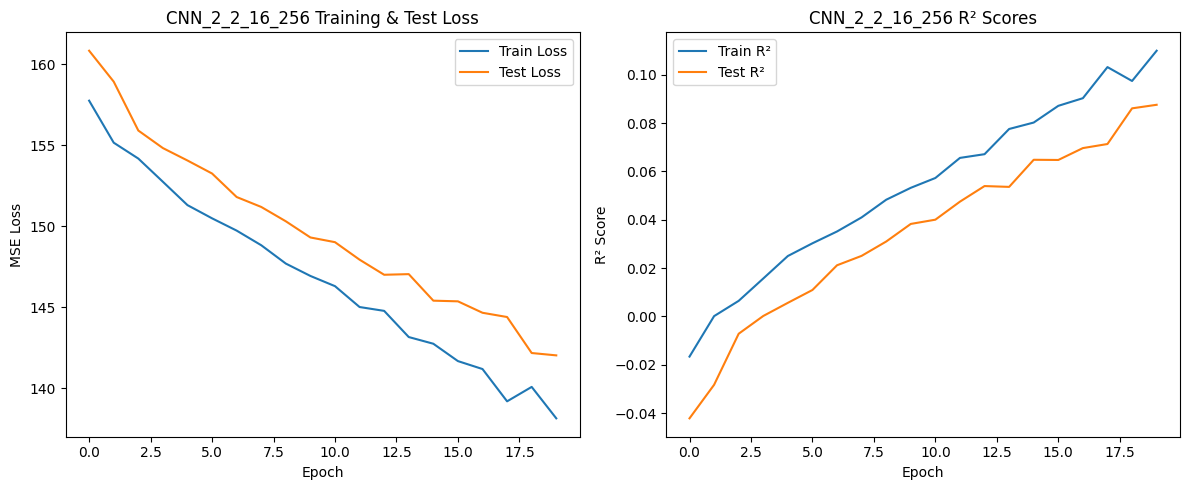

In [14]:
# session 8
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_512 Training Summary ===
Best Epoch: 19
Best Test Loss: 95.5309
Corresponding Test R²: 0.3753
Final Train Loss: 34.7561 ± 24.6654
Final Train R²: 0.7760 ± 0.1589
Final Test Loss: 170.9548 ± 72.4418
Final Test R²: -0.0856 ± 0.4708


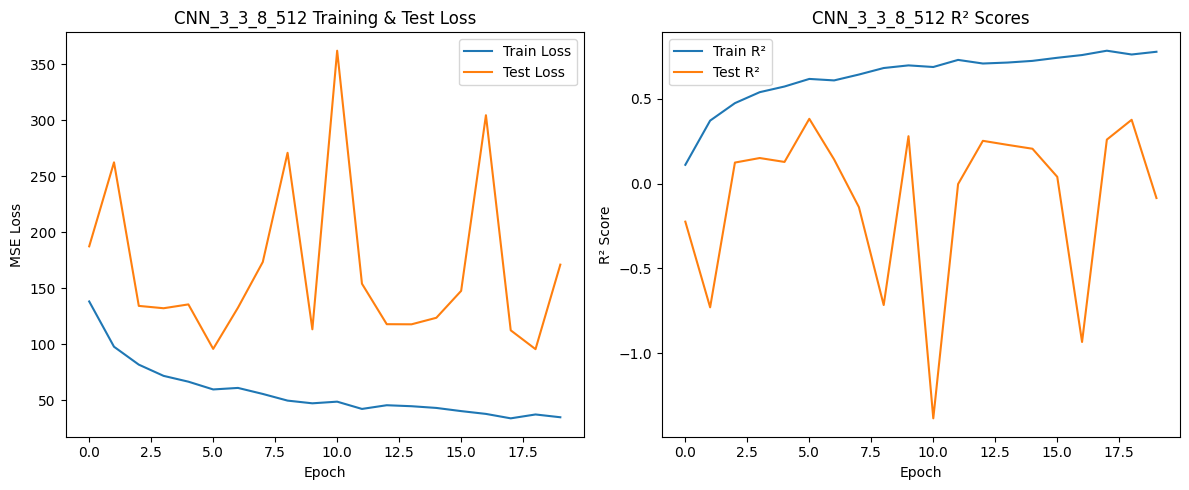

In [15]:
# session 9

results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_512 Training Summary ===
Best Epoch: 17
Best Test Loss: 96.2204
Corresponding Test R²: 0.3851
Final Train Loss: 69.3284 ± 27.1722
Final Train R²: 0.5533 ± 0.1751
Final Test Loss: 97.4060 ± 18.5939
Final Test R²: 0.3732 ± 0.1229


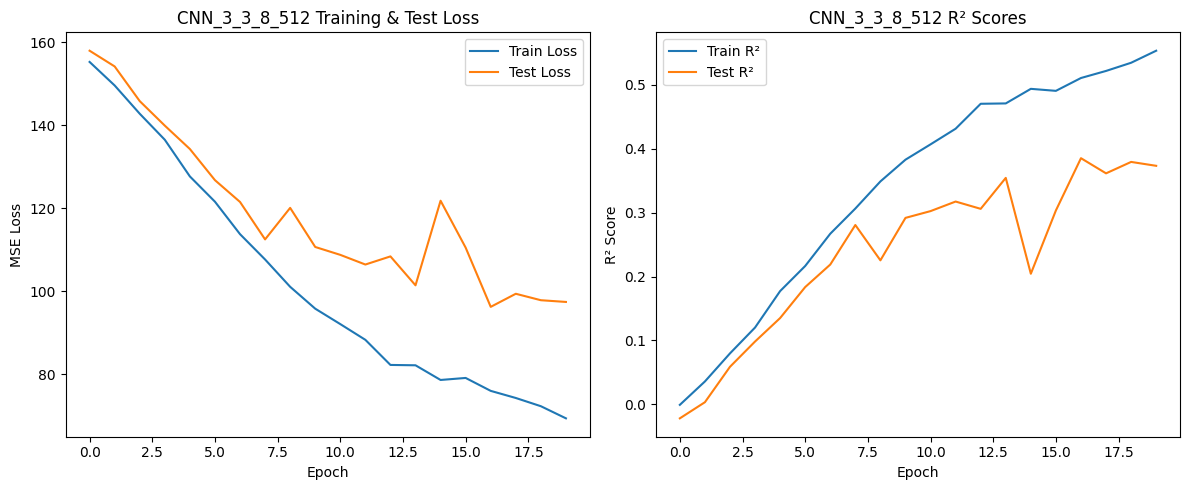

In [16]:
# session 10

results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_512 Training Summary ===
Best Epoch: 11
Best Test Loss: 107.6349
Corresponding Test R²: 0.3080
Final Train Loss: 76.7134 ± 22.0599
Final Train R²: 0.5057 ± 0.1422
Final Test Loss: 163.0320 ± 64.9731
Final Test R²: -0.0236 ± 0.4149


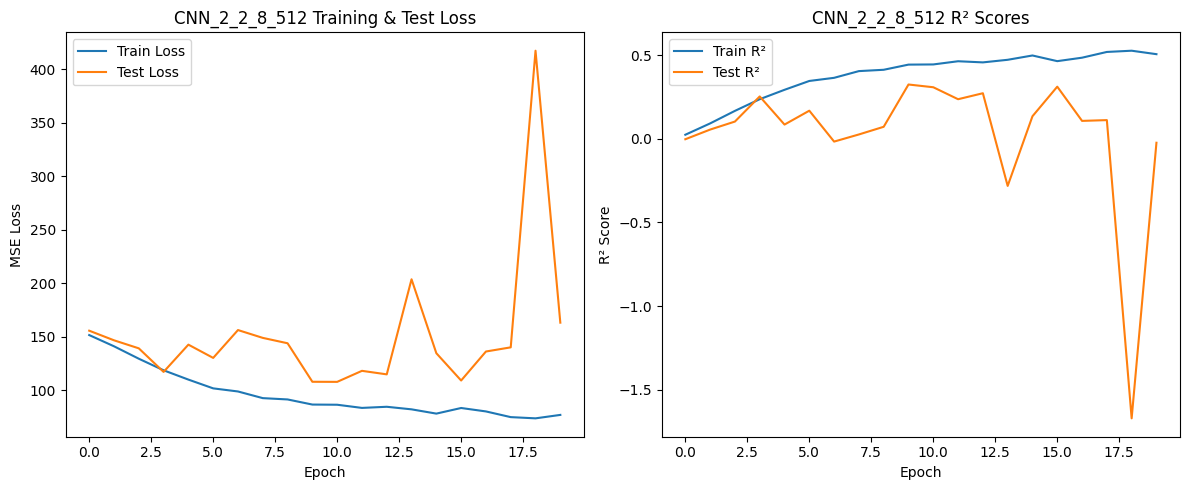

In [17]:
# session 11
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_512 Training Summary ===
Best Epoch: 20
Best Test Loss: 133.5655
Corresponding Test R²: 0.1449
Final Train Loss: 131.0150 ± 7.4413
Final Train R²: 0.1557 ± 0.0480
Final Test Loss: 133.5655 ± 7.2604
Final Test R²: 0.1449 ± 0.0496


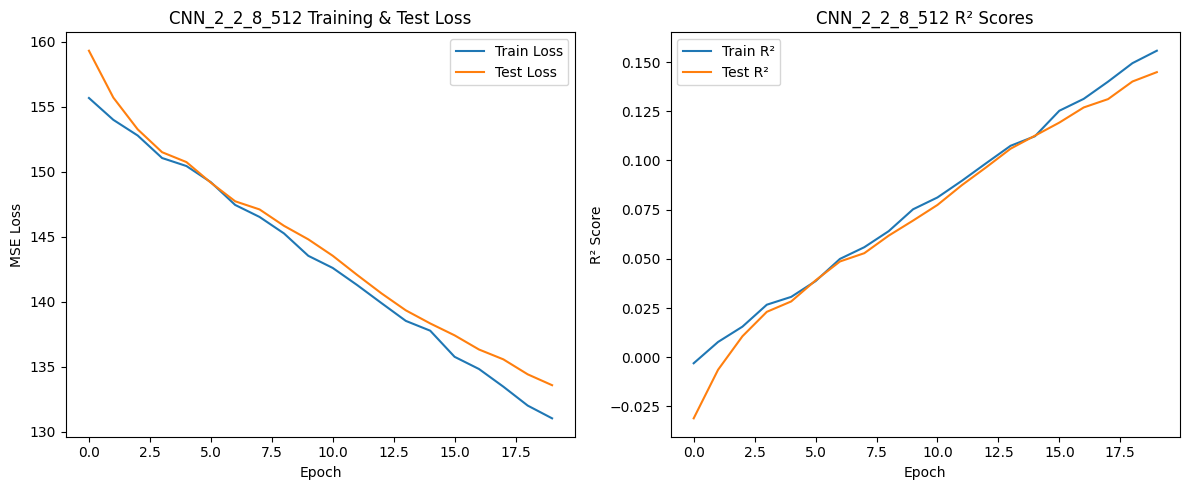

In [18]:
# session 12
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_256 Training Summary ===
Best Epoch: 5
Best Test Loss: 94.1962
Corresponding Test R²: 0.3985
Final Train Loss: 50.4129 ± 24.7059
Final Train R²: 0.6751 ± 0.1592
Final Test Loss: 202.8216 ± 192.3345
Final Test R²: -0.3388 ± 1.2748


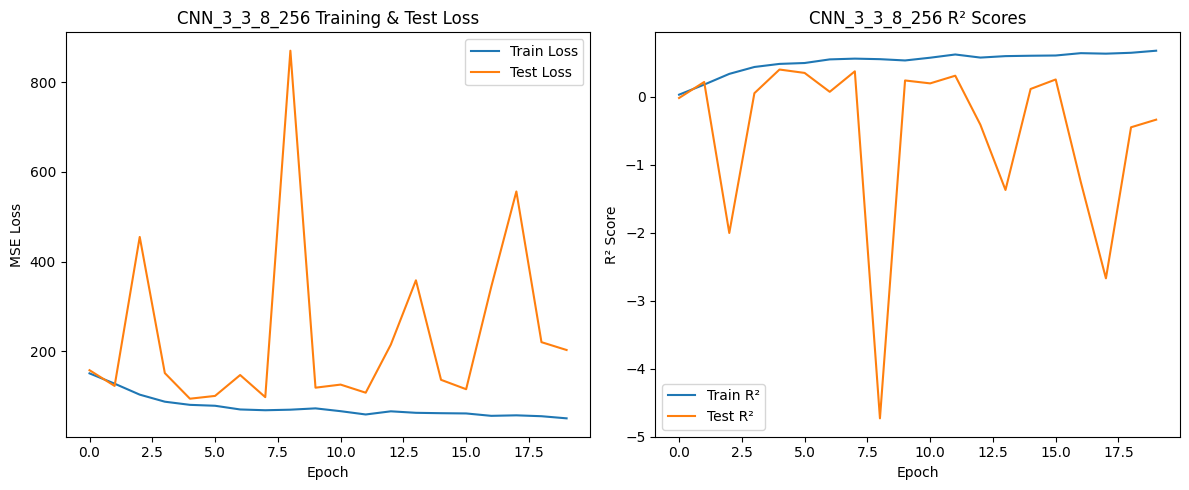

In [19]:
# session 13
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_256 Training Summary ===
Best Epoch: 20
Best Test Loss: 104.1278
Corresponding Test R²: 0.3351
Final Train Loss: 93.5276 ± 19.8757
Final Train R²: 0.3973 ± 0.1281
Final Test Loss: 104.1278 ± 15.9459
Final Test R²: 0.3351 ± 0.1056


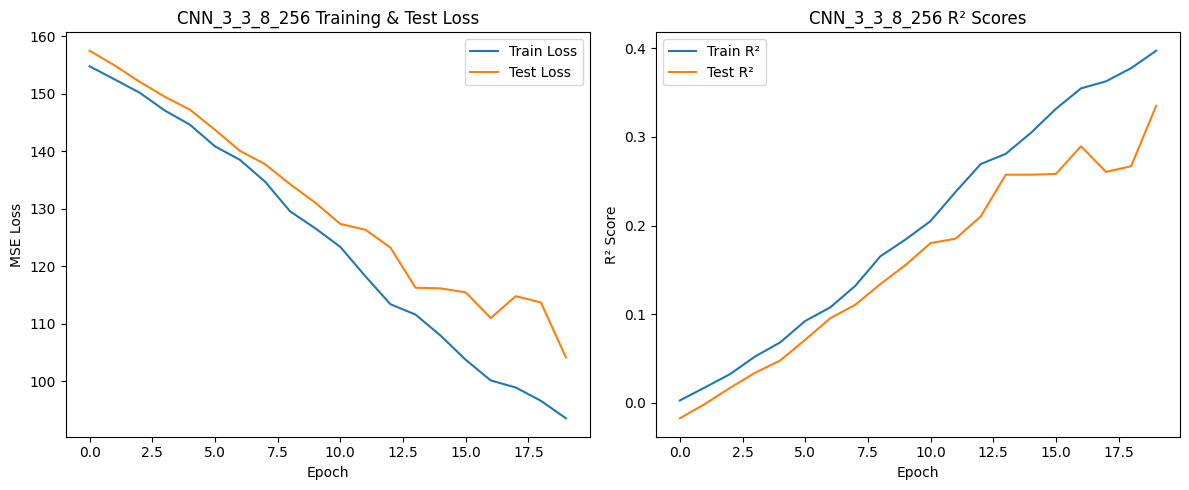

In [20]:
# session 14
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_256 Training Summary ===
Best Epoch: 14
Best Test Loss: 95.0930
Corresponding Test R²: 0.3978
Final Train Loss: 81.2416 ± 23.2310
Final Train R²: 0.4765 ± 0.1497
Final Test Loss: 150.1802 ± 41.0081
Final Test R²: 0.0580 ± 0.2739


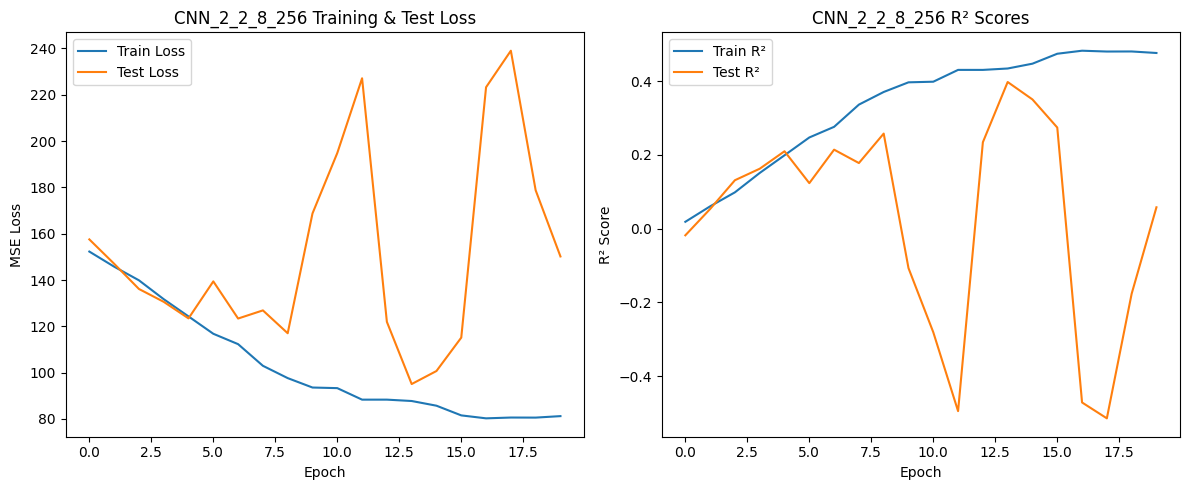

In [21]:
# session 15
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_256 Training Summary ===
Best Epoch: 20
Best Test Loss: 148.2768
Corresponding Test R²: 0.0433
Final Train Loss: 144.7901 ± 3.5838
Final Train R²: 0.0670 ± 0.0231
Final Test Loss: 148.2768 ± 3.1010
Final Test R²: 0.0433 ± 0.0210


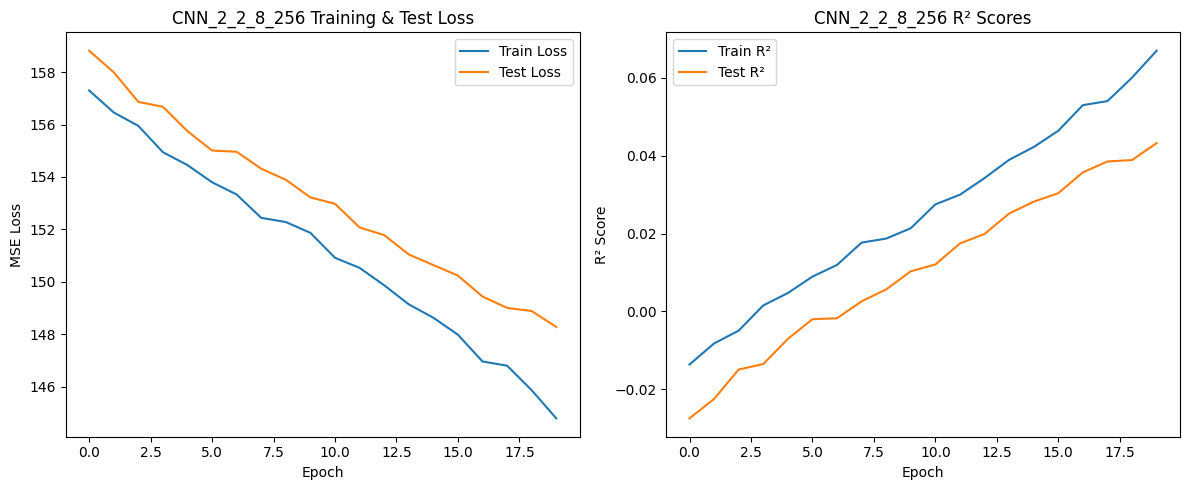

In [22]:
# session 16
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_128 Training Summary ===
Best Epoch: 19
Best Test Loss: 107.7164
Corresponding Test R²: 0.3100
Final Train Loss: 58.5185 ± 26.9517
Final Train R²: 0.6229 ± 0.1737
Final Test Loss: 109.9399 ± 100.7911
Final Test R²: 0.2982 ± 0.6377


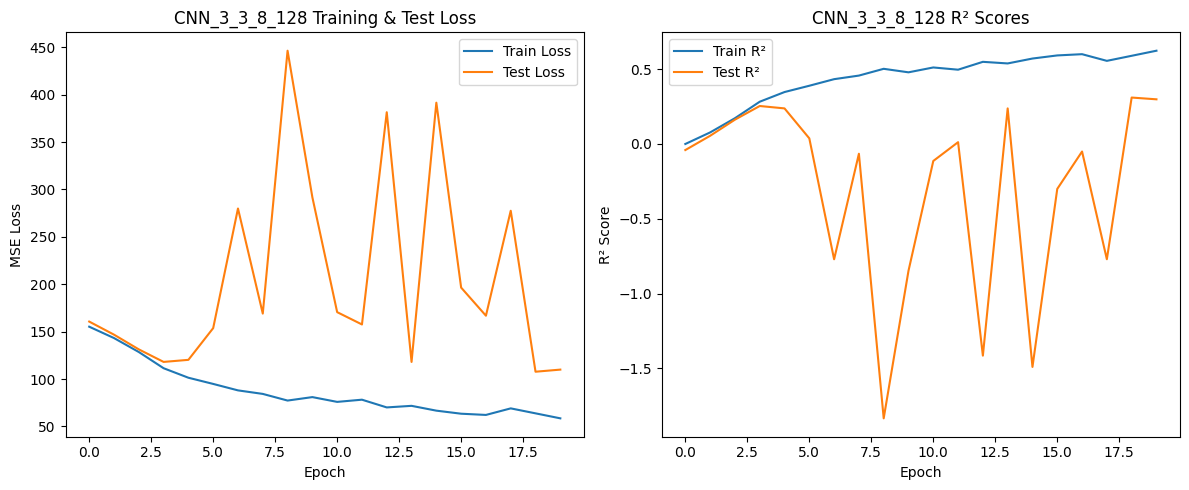

In [23]:
# session 17
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_128 Training Summary ===
Best Epoch: 18
Best Test Loss: 131.7323
Corresponding Test R²: 0.1508
Final Train Loss: 126.3676 ± 9.4222
Final Train R²: 0.1857 ± 0.0607
Final Test Loss: 134.6393 ± 8.1478
Final Test R²: 0.1299 ± 0.0538


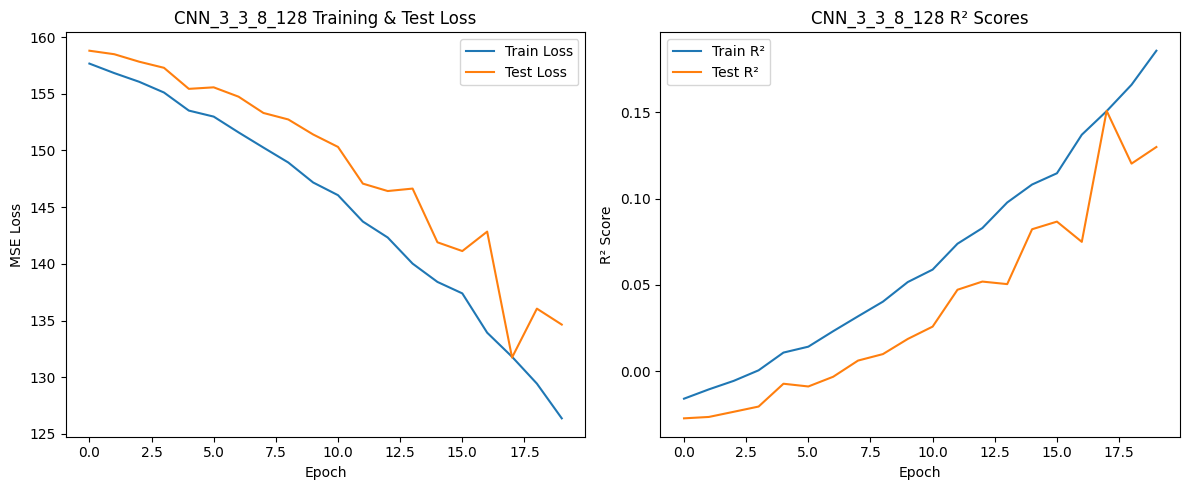

In [24]:
# session 18
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_128 Training Summary ===
Best Epoch: 12
Best Test Loss: 104.7270
Corresponding Test R²: 0.3308
Final Train Loss: 89.1866 ± 21.6046
Final Train R²: 0.4253 ± 0.1392
Final Test Loss: 140.4085 ± 229.7100
Final Test R²: 0.0799 ± 1.5093


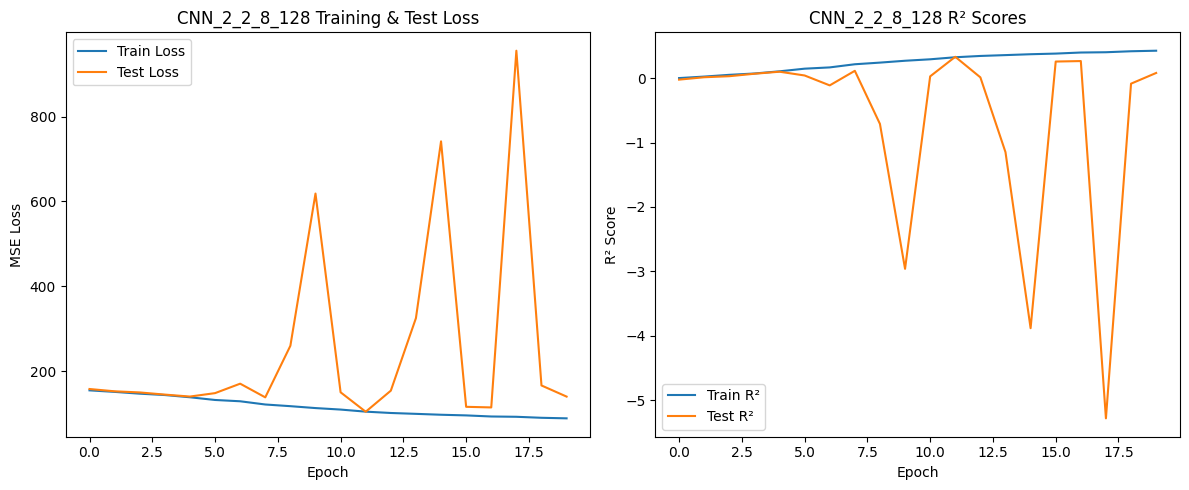

In [25]:
# session 19
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_128 Training Summary ===
Best Epoch: 20
Best Test Loss: 150.1515
Corresponding Test R²: 0.0338
Final Train Loss: 147.6855 ± 2.5327
Final Train R²: 0.0483 ± 0.0163
Final Test Loss: 150.1515 ± 2.1189
Final Test R²: 0.0338 ± 0.0149


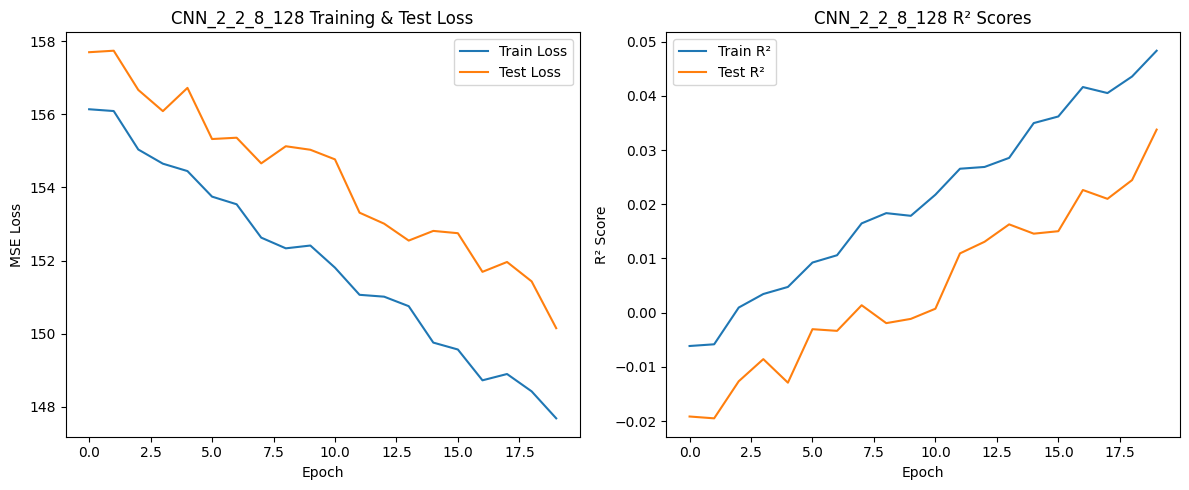

In [26]:
# session 20
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_128 Training Summary ===
Best Epoch: 6
Best Test Loss: 96.2386
Corresponding Test R²: 0.3945
Final Train Loss: 52.2456 ± 28.2678
Final Train R²: 0.6633 ± 0.1822
Final Test Loss: 120.0581 ± 202.4680
Final Test R²: 0.2143 ± 1.3081


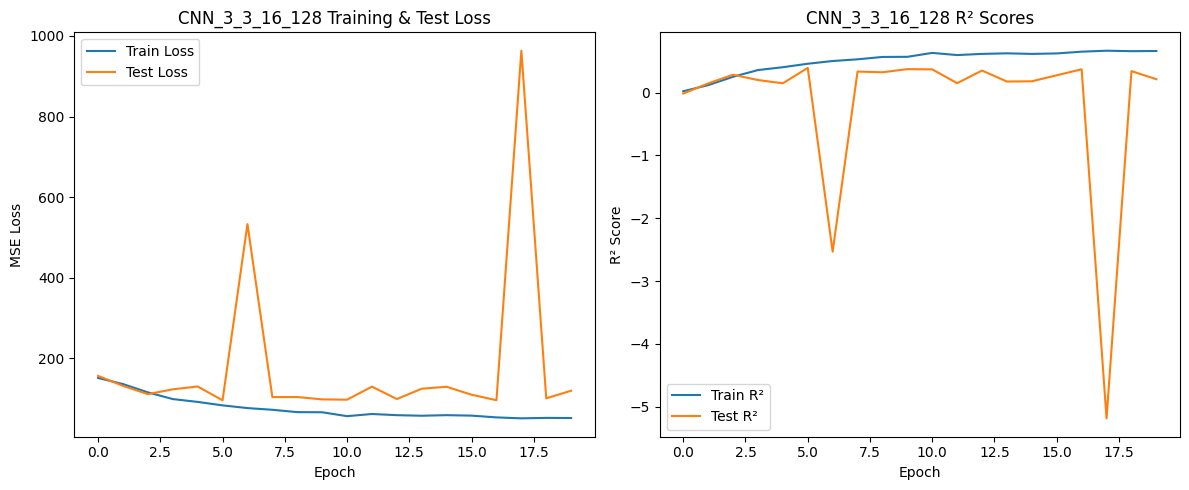

In [27]:
# session 21
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_128 Training Summary ===
Best Epoch: 19
Best Test Loss: 121.4489
Corresponding Test R²: 0.2191
Final Train Loss: 110.7792 ± 14.4793
Final Train R²: 0.2861 ± 0.0933
Final Test Loss: 121.6302 ± 11.5614
Final Test R²: 0.2160 ± 0.0759


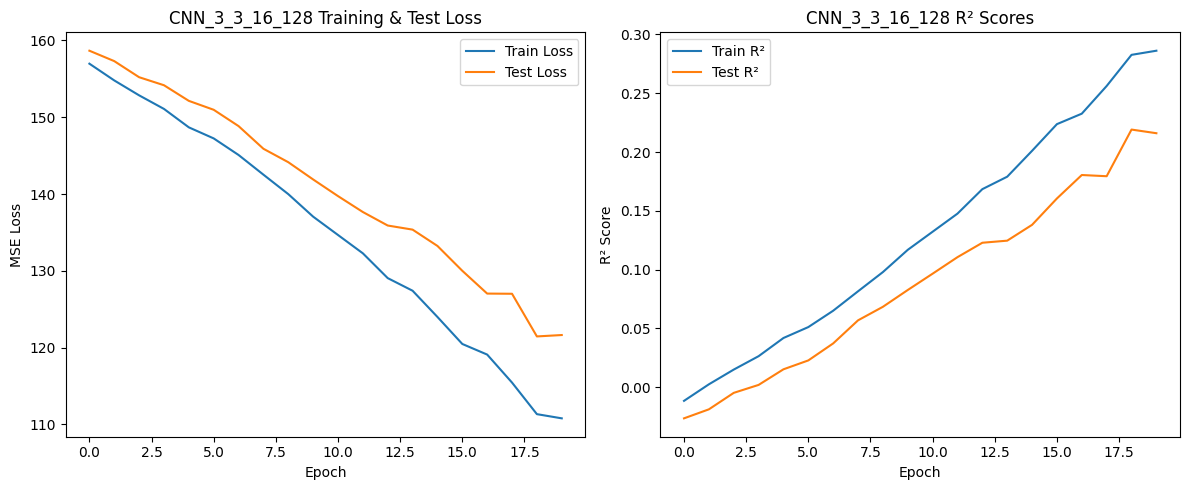

In [28]:
# session 22
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_128 Training Summary ===
Best Epoch: 17
Best Test Loss: 121.7179
Corresponding Test R²: 0.2148
Final Train Loss: 82.6707 ± 24.4083
Final Train R²: 0.4673 ± 0.1573
Final Test Loss: 232.6539 ± 84.5126
Final Test R²: -0.5259 ± 0.5356


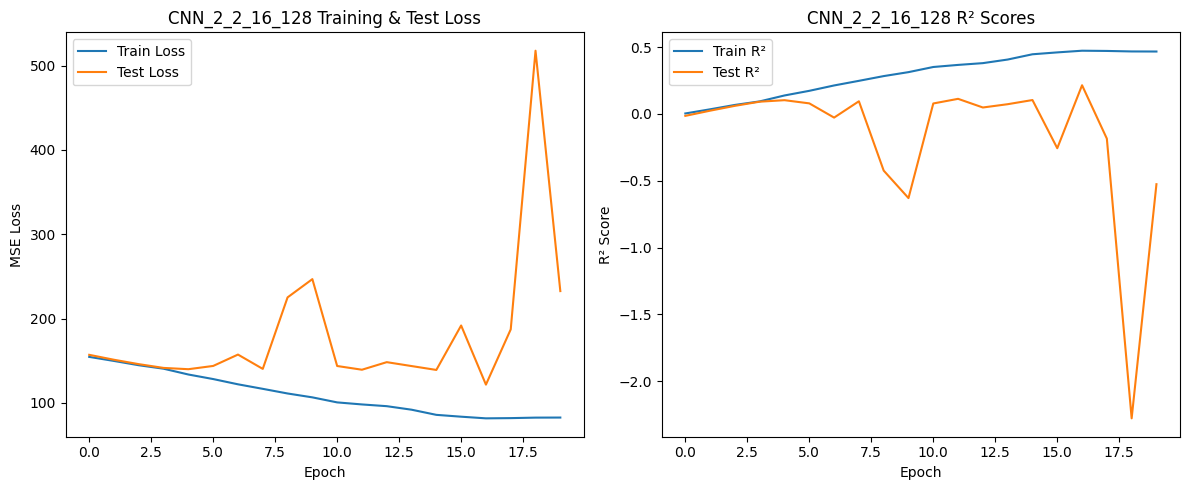

In [29]:
# session 23
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_128 Training Summary ===
Best Epoch: 20
Best Test Loss: 146.7698
Corresponding Test R²: 0.0534
Final Train Loss: 142.4529 ± 3.7097
Final Train R²: 0.0820 ± 0.0239
Final Test Loss: 146.7698 ± 3.4664
Final Test R²: 0.0534 ± 0.0234


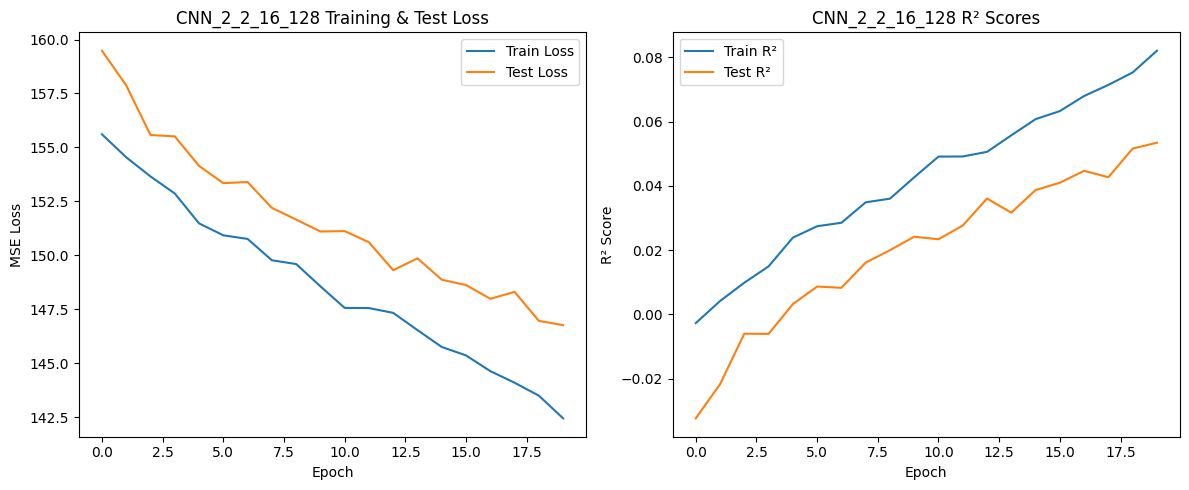

In [30]:
# session 24
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)